In [97]:
! pip install -U chainer==2.0

Requirement already up-to-date: chainer==2.0 in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages
Requirement already up-to-date: protobuf>=2.6.0 in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: numpy>=1.9.0 in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: six>=1.9.0 in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: nose in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
Requirement already up-to-date: filelock in /Users/matuura/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages (from chainer==2.0)
    100% |████████████████████████████████| 491kB 329kB/s ta 0:00:01   16% |█████▍                          | 81kB 118kB/s eta 0:00:04
  Found existing installation: setupto

In [98]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import chainer
import chainer.functions as F  
import chainer.links as L               
from chainer import computational_graph 
from chainer import serializers     

In [99]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [100]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [101]:
len(y_train)

60000

In [122]:
X_train = X_train.astype(np.float32)
y_train= y_train.astype(np.int32)
X_test = X_test.astype(np.float32)
y_test= y_test.astype(np.int32)

In [103]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=int32)

In [116]:
X_train[0]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
         13.,   73.,    0.,    0.,    1.,    4.,    0.,    0.,    0.,
          0.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    3.,    0.,
         36.,  136.,

In [125]:
y_train[0]

9

In [123]:
X_train.max()
X_test.max()

255.0

In [127]:
X_train /= X_train.max()

In [128]:
X_test /= X_test.max()

In [129]:
X_train.shape

(60000, 784)

In [130]:
y_train.shape

(60000,)

In [131]:
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

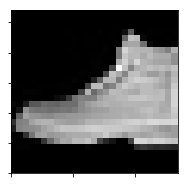

In [132]:
index = 50000
draw_digit(X_train[index])

In [133]:
y_train[index]

9

In [134]:
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 900)  # 第1層からの入力784､第2層への出力900
            self.l2=L.Linear(900, 1000) # 第2層からの入力600､第3層への出力1000
            self.l3=L.Linear(1000, 500) # 第3層からの入力1000､第4層への出力500
            self.l4=L.Linear(500, 10)   # 第4層からの入力500､出力層への出力10
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  # 1つめの隠れ層からの出力を計算
        h2 = F.relu(self.l2(h1)) # 2つめの隠れ層からの出力を計算
        h3 = F.relu(self.l3(h2)) # 3つめの隠れ層からの出力を計算
        return self.l4(h3)       # 出力層への入力を返す

In [135]:
model = L.Classifier(MLP())

In [136]:
gpu = -1 

In [137]:
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)   

In [138]:
batch_size = 100
n_epoch = 20

In [139]:
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [140]:
train = tuple_dataset.TupleDataset(X_train, y_train)

In [141]:
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [142]:
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)

In [143]:
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [144]:
test = tuple_dataset.TupleDataset(X_test,y_test)

In [145]:
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)

In [146]:
trainer.extend(extensions.Evaluator(test_iter, model))

In [147]:
trainer.extend(extensions.LogReport())

In [148]:
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [149]:
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [150]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           1.05803     0.684467       0.683416              0.7692                    
2           0.589372    0.799433       0.563817              0.8004                    
3           0.510544    0.822517       0.503077              0.8251                    
4           0.472658    0.834783       0.474333              0.834                     
5           0.450711    0.842567       0.464966              0.8372                    
6           0.43217     0.84935        0.443449              0.8419                    
7           0.41798     0.854033       0.442864              0.8449                    
8           0.404411    0.857683       0.429219              0.8472                    
9           0.39403     0.861717       0.421294              0.8525                    
10          0.382914    0.8654         0.415031              0.852                     
11          0.375589    0.86755   

In [151]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

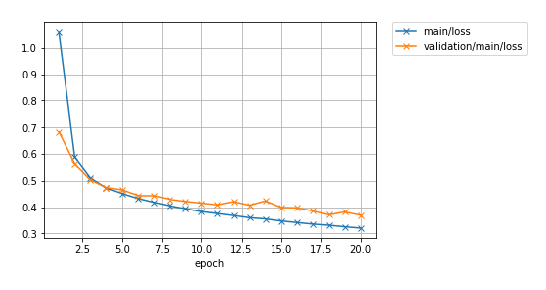

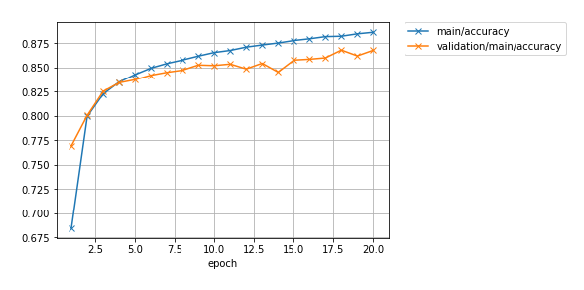

In [152]:
show_graph('result/loss.png')
show_graph('result/accuracy.png')